In [1]:
#Load dependence
import pandas as pd
import numpy as np
from rdkit import Chem
import os
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

from MultiTaskGNN.utils import gen_mol_form_smi, gen_ortho_sub_list, gen_meta_sub_list, make_reaction_graphs
from MultiTaskGNN.MT_GNN import MultiTaskDataset, MultiTaskGNN, evaluate

In [2]:
#Load raw data
df = pd.read_csv('./RuCHFunctionalizationDataset/dataset.csv')
df_DG = pd.read_csv('./RuCHFunctionalizationDataset/DG.csv')
df_RX = pd.read_csv('./RuCHFunctionalizationDataset/RX.csv')

cat_smi_list = df['catalyst'].to_list()
sol_smi_list = df['solvent'].to_list()
ligand_smi_list = df['ligand'].to_list()
ad_smi_list = df['addictive'].to_list()

In [3]:
#Transform the SMILES of four reaction components into MOL files
cat_mols = gen_mol_form_smi(cat_smi_list)
ligand_mols = gen_mol_form_smi(ligand_smi_list)
sol_mols = gen_mol_form_smi(sol_smi_list)
ad_mols = gen_mol_form_smi(ad_smi_list)

In [4]:
#Load target for the classification task
target = df['tag'].to_list()
target = np.array(target)

num = df['number'].to_list()
num = np.array(num)
num_DG = df['DG_num'].to_list()
num_DG = np.array(num_DG)
num_RX = df['RX_num'].to_list()
num_RX = np.array(num_RX)

In [5]:
#Prepare mechanistic-related discriptors for DG and RX
f_p_2 = df_DG['f+2'].tolist()
f_p_3 = df_DG['f+3'].tolist()
f_p_4 = df_DG['f+4'].tolist()
f_p_5 = df_DG['f+5'].tolist()
f_p_6 = df_DG['f+6'].tolist()
fukui1 = np.column_stack((f_p_2, f_p_3, f_p_4, f_p_5, f_p_6))

f_m_2 = df_DG['f-2'].tolist()
f_m_3 = df_DG['f-3'].tolist()
f_m_4 = df_DG['f-4'].tolist()
f_m_5 = df_DG['f-5'].tolist()
f_m_6 = df_DG['f-6'].tolist()
fukui2 = np.column_stack((f_m_2, f_m_3, f_m_4, f_m_5, f_m_6))

f_0_2 = df_DG['f0-2'].tolist()
f_0_3 = df_DG['f0-3'].tolist()
f_0_4 = df_DG['f0-4'].tolist()
f_0_5 = df_DG['f0-5'].tolist()
f_0_6 = df_DG['f0-6'].tolist()
fukui3 = np.column_stack((f_0_2, f_0_3, f_0_4, f_0_5, f_0_6))

Q_2 = df_DG['Q2'].tolist()
Q_3 = df_DG['Q3'].tolist()
Q_4 = df_DG['Q4'].tolist()
Q_5 = df_DG['Q5'].tolist()
Q_6 = df_DG['Q6'].tolist()
Qc_DG = np.column_stack((Q_2, Q_3, Q_4, Q_5, Q_6))

Qc_R = df_RX['Qc'].tolist()
Qc_R = np.array(Qc_R)
f0 = df_RX['f0'].tolist()
f0 = np.array(f0)
f_m = df_RX['f-'].tolist()
f_m = np.array(f_m)
f_p = df_RX['f+'].tolist()
f_p = np.array(f_p)

In [6]:
#Load targets for the two regression task of DG and RX
target_columns_DG = ['homo', 'lumo', 'dipole', 'EA', 'bv-3.5', 'bv-5']
target_DG = df_DG[target_columns_DG].values.tolist()
target_DG = np.array(target_DG)

target_columns_RX = ['homo', 'lumo', 'dipole', 'EA', 'bv-3.5', 'bv-5']
target_RX = df_RX[target_columns_RX].values.tolist()
target_RX = np.array(target_RX)

In [7]:
#Create dictionaries for DG
DG_mol_folder_path = 'RuCHFunctionalizationDataset/train_DG'
DG_mols_list = []
for filename in sorted(os.listdir(DG_mol_folder_path), key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')):
    mol_file_path = os.path.join(DG_mol_folder_path, filename)
    mol = Chem.MolFromMolFile(mol_file_path, removeHs=False)   
    if mol is not None:
        DG_mols_list.append(mol)
    else:
        print(f"Failed to load molecule from {mol_file_path}")

DG_dict = {}
for idx, mol in enumerate(DG_mols_list):
    DG_id = str(idx + 1)
    DG_dict[DG_id] = mol
    
DG_mols_for_r = []
for i in num:
    DG_number = num_DG[i]
    DG_mol = DG_dict[str(DG_number)]
    DG_mols_for_r.append(DG_mol)
    
train_val_num = len(DG_mols_for_r)

In [8]:
#Create dictionaries for RX    
RX_mol_folder_path = 'RuCHFunctionalizationDataset/train_RX'
RX_mols_list = []
for filename in sorted(os.listdir(RX_mol_folder_path), key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')):
    mol_file_path = os.path.join(RX_mol_folder_path, filename)
    mol = Chem.MolFromMolFile(mol_file_path, removeHs=False)   
    if mol is not None:
        RX_mols_list.append(mol)
    else:
        print(f"Failed to load molecule from {mol_file_path}")

RX_dict = {}
for idx, mol in enumerate(RX_mols_list):
    RX_id = str(idx + 1)
    RX_dict[RX_id] = mol
    
RX_mols_for_r = []
for i in num:
    RX_number = num_RX[i]
    RX_mol = RX_dict[str(RX_number)]
    RX_mols_for_r.append(RX_mol)

In [9]:
#Find ortho- and meta-substituted DG
ortho_sub_list = gen_ortho_sub_list(DG_mols_for_r)
meta_sub_list = gen_meta_sub_list(DG_mols_for_r)

In [10]:
#Create reaction graphs            
v1_graphs, v2_graphs, reaction_graphs, decs, decs_mp, DG_graphs, RX_graphs = make_reaction_graphs(DG_mols_for_r,RX_mols_for_r,fukui1,fukui2,fukui3,Qc_DG,Qc_R,f0,f_m,f_p,ligand_mols,cat_mols,sol_mols,ad_mols)
reaction_graphs = np.array(reaction_graphs)
DG_graphs = np.array(DG_graphs)
RX_graphs = np.array(RX_graphs)

In [11]:
#Prepare dataset
target = torch.tensor(target, dtype=torch.long)
num = torch.tensor(num, dtype=torch.long)
target_DG = torch.tensor(target_DG, dtype=torch.float)
target_RX = torch.tensor(target_RX, dtype=torch.float)
dataset = MultiTaskDataset(DG_graphs, RX_graphs, reaction_graphs, target_DG, target_RX, target, num)

dataloader = GraphDataLoader(
    dataset,
    batch_size=30,
    drop_last=False,
    shuffle=True)

In [12]:
#Training
kf = KFold(n_splits=10, shuffle=True,random_state=1)
fold_num = 1
all_acc_list = []
all_loss_list = []
r2_1_all_list = []
r2_2_all_list = []
MAE1_all_list = []
MAE2_all_list = []
target_list_cm = []
pred_list_cm = []
output1_list = []
loss_list = []
loss_list1 = []
loss_list2 = []
train_acc_list = []
valid_acc_list = []
MAE1_val_list = []
MAE2_val_list = []
r2_1_val_list = []
r2_2_val_list = []
attention_DG_all = torch.empty(0)
h3_all = torch.empty(0)

start_time = time.time()
for train_indices, val_indices in kf.split(dataset):
    print('train indices:', train_indices)
    print('validation indices:', val_indices)
        
    train_dataset = [dataset[i] for i in train_indices]
    val_dataset = [dataset[i] for i in val_indices]

    train_loader = GraphDataLoader(
        train_dataset,
        batch_size=30,
        drop_last=False,
        shuffle=True)
    
    val_loader = GraphDataLoader(
        val_dataset,
        batch_size=30,
        drop_last=False,
        shuffle=True)
    
    model = MultiTaskGNN(79, 250, 6, 6, 5)# The original dimension of the reaction graph is 79
    opt = torch.optim.Adam(model.parameters())
    
    predicted_val_list = []
    labels_val_list = []
    num_val_list = []
    
    for epoch in range(250):
        model.train()
        for inputs_task1, inputs_task2, inputs_task3, labels_task1, labels_task2, labels_task3, num in train_loader:
            opt.zero_grad()
            
            feat3 = inputs_task3.ndata['h']
            feat2 = inputs_task2.ndata['nfeat']
            feat1 = inputs_task1.ndata['nfeat']
            
            output1, output2, output3, attention_DG, attention_r, weight, h3 = model(inputs_task1, inputs_task2, inputs_task3, feat1, feat2, feat3)
            output1_list.extend(output1)
            
            loss1 = F.mse_loss(output1, labels_task1)
            loss2 = F.l1_loss(output2, labels_task2)
            loss3 = F.cross_entropy(output3, labels_task3)
            total_loss = loss1*0.4 + loss2*0.4 + loss3*0.2
            
            total_loss.backward()
            opt.step()

        train_acc, predicted_train, labels_train, num_train, MAE1_t, MAE2_t, r2_1_t, r2_2_t, attention_DG_t, attention_r_t, weight_t, h3_t = evaluate(model, train_loader, ortho_sub_list, meta_sub_list)
        train_acc_list.append(train_acc)
        valid_acc, predicted_val, labels_val, num_val, MAE1_val, MAE2_val, r2_1_val, r2_2_val, attention_DG_v, attention_r_v, weight_v, h3_v = evaluate(model, val_loader, ortho_sub_list, meta_sub_list)
        valid_acc_list.append(valid_acc)
        predicted_val_list.append(predicted_val)
        labels_val_list.append(labels_val)
        num_val_list.append(num_val)
        MAE1_val_list.append(MAE1_val)
        MAE2_val_list.append(MAE2_val)
        r2_1_val_list.append(r2_1_val)
        r2_2_val_list.append(r2_2_val)
        loss4 = total_loss
        loss4 = loss4.detach()
        loss1 = loss1.detach()
        loss2 = loss2.detach()
        loss4 = loss4.numpy()
        loss1 = loss1.numpy()
        loss2 = loss2.numpy()
        loss_list.append(loss4)
        loss_list1.append(loss1)
        loss_list2.append(loss2)
        
        if epoch == 249:
            attention_DG_all = torch.cat((attention_DG_all, attention_DG_v), dim=0)
            h3_all =torch.cat((h3_all, h3_v), dim=0)
    
    temp1 = labels_val_list[-1].tolist()
    temp2 = predicted_val_list[-1].tolist()
    target_list_cm.extend(temp1)
    pred_list_cm.extend(temp2)
    
    print(
        "Fold {:02d} | Loss {:.4f} | Train Classification Acc. {:.4f} | Validation Classification Acc. {:.4f} ".format(
        fold_num, loss_list[-1] , train_acc_list[-1], valid_acc_list[-1])
        )
    all_acc_list.append(valid_acc_list[-1])
    all_loss_list.append(loss_list[-1])
    r2_1_all_list.append(r2_1_val_list[-1])
    r2_2_all_list.append(r2_2_val_list[-1])
    MAE1_all_list.append(MAE1_val_list[-1])
    MAE2_all_list.append(MAE2_val_list[-1])
    fold_num += 1

average_accuracy = np.mean(all_acc_list)
average_loss = np.mean(all_loss_list)
average_r2_1 = np.mean(r2_1_all_list)
average_r2_2 = np.mean(r2_2_all_list)
average_MAE1 = np.mean(r2_1_all_list)
average_MAE2 = np.mean(r2_2_all_list)
print("Accuracy_classification {:.4f}, Loss {:.4f}, R2_DG {:.4f}, R2_RX {:.4f}, MAE1 {:.4f}, MAE2 {:.4f}".format(average_accuracy, average_loss, average_r2_1, average_r2_2, average_MAE1, average_MAE2))
end_time = time.time()
print(f"Running time: {end_time - start_time} s")

train indices: [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  33  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  59  60  61  62  63  64  65  66  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  90  91  92  94  95  96  97
  98  99 100 101 102 103 104 105 106 108 109 110 111 112 113 114 115 117
 119 120 121 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171 172 173 174
 175 177 178 179 181 183 184 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 206 207 208 209 210 211 212 213 214 218
 219 220 221 222 224 225 226 227 228 229 230 231 232 233 234 235 236 239]
validation indices: [  4  27  34  51  58  67  89  93 107 116 118 122 169 176 180 182 185 205
 215 216 217 22

Text(50.722222222222214, 0.5, 'True')

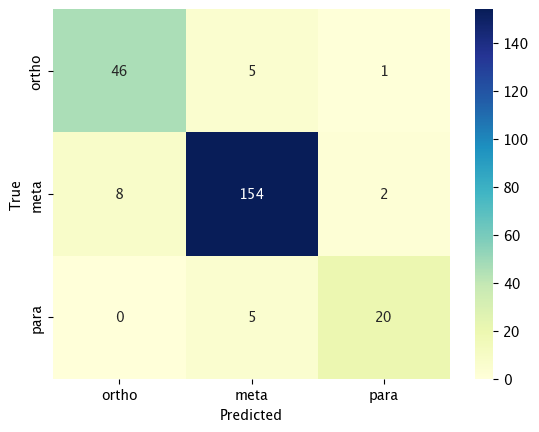

In [13]:
target_list_cm = [0 if x == 4 else x for x in target_list_cm]
pred_list_cm = [0 if x == 4 else x for x in pred_list_cm]
cm_1 = confusion_matrix(target_list_cm, pred_list_cm)
cm_1 = pd.DataFrame(cm_1,columns=["ortho","meta","para"],index=["ortho","meta","para"])
p = sns.heatmap(cm_1,cmap="YlGnBu",fmt="d",annot=True)
p.set_xlabel('Predicted')
p.set_ylabel('True')